## PulsarClassifier.ipynb

‹ PulsarClassifier.ipynb › Copyright (C) ‹ 2019 › ‹ Anna Scaife - anna.scaife@manchester.ac.uk › 

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

**This notebook was created for the CHPC/NITheP [2019 Chris Engelbrecht Summer School](https://quantum.ukzn.ac.za/2019-chris-engelbrecht-summer-school/) on the Foundations of Theoretical and Computational Science.** It was inspired by [Rob Lyon](http://www.scienceguyrob.com)'s pulsar classification tutorials in the [IAU OAD Data Science Toolkit](https://github.com/astro4dev/OAD-Data-Science-Toolkit/tree/master/Teaching%20Materials/Machine%20Learning/Supervised%20Learning/Examples/PPC).

---

First we import some libraries:

In [1]:
import numpy as np   # for array stuff
import pylab as pl   # for plotting stuff

We'll use the scikit-learn library for the machine learning tasks, so let's import a whole bunch of stuff from there:

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

This library is useful for making evaluation plots:

In [3]:
import scikitplot as skplt

This library is for data handling:

In [4]:
import pandas as pd  

---

We're going to import the [HTRU2 dataset](https://archive.ics.uci.edu/ml/datasets/HTRU2):

In [5]:
df = pd.read_csv('data/pulsar.csv')

The first row of the CSV file tells us what the features are:

In [6]:
feature_names = df.columns.values[0:-1]
print(feature_names)

['mean_int_pf' 'std_pf' 'ex_kurt_pf' 'skew_pf' 'mean_dm' 'std_dm'
 'kurt_dm' 'skew_dm']


and we can check just how much data we're dealing with:

In [7]:
# Show some information
print ('Dataset has %d rows and %d columns including features and labels'%(df.shape[0],df.shape[1]))

Dataset has 17898 rows and 9 columns including features and labels


We're going to start by separating the numerical feature data from class labels for all the candidates. To get the feature data on its own we can just strip off the column containing the class labels:

In [8]:
features = df.drop('class', axis=1)

The labels for each object tell us abut the target class and we can create an array of those data by extracting the column from the original dataset:

In [9]:
targets = df['class']

Let's take a look at how the two classes are distributed in parameter space. We'll plot the value of one feature against another and colour code the data samples according to their class.

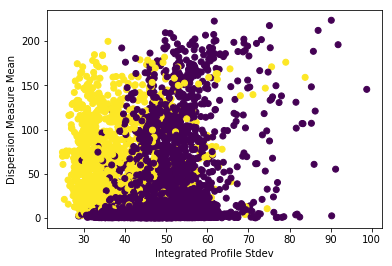

In [10]:
pl.subplot(111)
pl.scatter(df['std_pf'], df['mean_dm'],c=df['class'])
pl.xlabel('Integrated Profile Stdev')
pl.ylabel('Dispersion Measure Mean')
pl.show()

**Exercise:** try plotting different combinations of features and see if there are any clear divisions.

---

Now we need to split our labelled data into two separate datasets: one to train the classifier and one to test the fitted machine learning model. 

To do this we can use the function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from the [scikit_learn](https://scikit-learn.org) library:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.33, random_state=66)

---

At this point we now have our dataset in the suitable state to start training our classifier. 

To start with we need to initiate the random forest classifier from [scikit_learn]():

In [12]:
RFC = RandomForestClassifier(n_jobs=2,n_estimators=10)

...and we can immediately fit the machine learning model to our training data:

In [13]:
RFC.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

We can then used the trained classifier to predict the label for the test data that we split out earlier:

In [14]:
rfc_predict = RFC.predict(X_test)

So how did we do? We need to evaluate the performance of our classifier.

A good first step is to evaluate the [cross-validation](https://www.openml.org/a/estimation-procedures/1):

In [15]:
rfc_cv_score = cross_val_score(RFC, features, targets, cv=10, scoring='roc_auc')

Let's print out the various evaluation criteria:

In [16]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict, target_names=['Non Pulsar','Pulsar']))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[5328   34]
 [ 100  445]]


=== Classification Report ===
              precision    recall  f1-score   support

  Non Pulsar       0.98      0.99      0.99      5362
      Pulsar       0.93      0.82      0.87       545

   micro avg       0.98      0.98      0.98      5907
   macro avg       0.96      0.91      0.93      5907
weighted avg       0.98      0.98      0.98      5907



=== All AUC Scores ===
[0.92445174 0.94711697 0.96197462 0.95943959 0.98134544 0.94502258
 0.96367339 0.95585268 0.95773708 0.95761963]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9554233723042751


We can make a more visual representation of the confusion matrix using the [scikit-plot]() library. To do this we need to know the predictions from our cross validation, rather than the Area Under Curve ([AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)) value:

In [17]:
predictions = cross_val_predict(RFC, features, targets, cv=10)

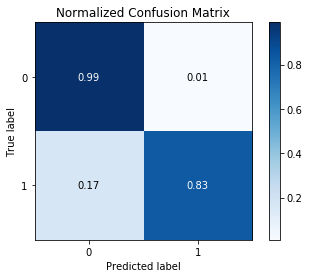

In [18]:
skplt.metrics.plot_confusion_matrix(targets, predictions, normalize=True)

To plot the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) we need to find the probabilities for each target class separately. We can do this with the [predict_proba]() function:

In [19]:
probas = RFC.predict_proba(X_test)

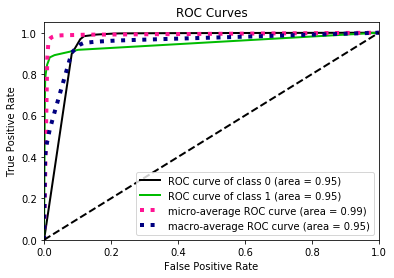

In [20]:
skplt.metrics.plot_roc(y_test, probas)

**Question:** What is the difference between the RFC.predict( ) function and the RFC.predict_proba( ) function?

We can use the output of the RFC.predict_proba( ) function to plot a Precision-Recall Curve. Recall that,

$$Precision = \frac{TP}{TP+FP},$$

$$Recall = \frac {TP}{TP+FN}.$$

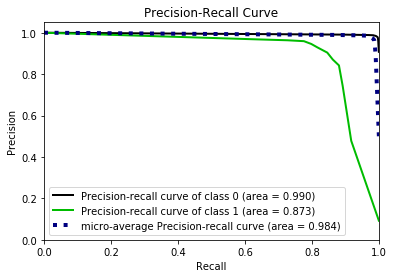

In [21]:
skplt.metrics.plot_precision_recall(y_test, probas)

When we initiated the random forest classifier we picked a value for the number of trees in our forest - but how do we know that this is the best possible value? 

We can use a "grid search" to loop through different options (e.g. number of trees, number of features for each tree, maximum depth of a tree) and tell us which one performs best.

In [22]:
from sklearn.model_selection import RandomizedSearchCV

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)

# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }

# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = RFC, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the model
rfc_random.fit(X_train, y_train)

# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 22.2min finished


{'n_estimators': 100, 'max_features': 'auto', 'max_depth': 220}


We can then re-run our training with the optimal parameters.

**Exercise:** Can you re-write the first line of Python in the next cell so that it automatically uses the best parameters?

In [ ]:
rfc = RandomForestClassifier(n_estimators=2000, max_depth=100, max_features='sqrt')
rfc.fit(X_train,y_train)
rfc_predict = RFC.predict(X_test)
rfc_cv_score = cross_val_score(RFC, features, targets, cv=10, scoring='roc_auc')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict, target_names=['Non Pulsar','Pulsar']))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

Let's take a look at the relative importance of the different features that we fed to our classifier:

In [ ]:
importances = RFC.feature_importances_
indices = np.argsort(importances)

In [ ]:
pl.figure(1)
pl.title('Feature Importances')
pl.barh(range(len(indices)), importances[indices], color='b', align='center')
pl.yticks(range(len(indices)), feature_names[indices])
pl.xlabel('Relative Importance')
 
pl.show()

**Question:** How do our results compare to the [results from the GH-VFDT classifier](https://www.research.manchester.ac.uk/portal/files/36794595/MNRAS_2016_Lyon_1104_23.pdf)?